# Combining the Data

Here I will combine it into a SQL data set. I will also visualize the data.

# Intro
First, let me explain how I'm going to combine my data sets. The first two data sets are of artificial satellites around Earth each has an identifier number, marked by 'NORAD Number'. This is the key I will use to join my data sets together. Then I will merge the third data set. That is a set of entirely different objects, in fact natural objects that are found in the solar system. Since there is no shared identifier like in the other two, I will concatenate that data set on top of (or below, doesn't matter) the other two.

In [1]:
# imports
import sqlite3
import pandas as pd
import sqlalchemy as sqla
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# first load the dataframes
df_1 = pd.read_csv('data/df_1.csv')
df_1.columns = df_1.columns.str.replace(' ','_')

df_2 = pd.read_csv('data/df_2.csv')
df_2.columns = df_2.columns.str.replace(' ','_')

df_3 = pd.read_csv('data/df_3.csv')
df_3.columns = df_3.columns.str.replace(' ','_')

In [3]:
# make final table
df_123 = pd.concat([df_1, df_2, df_3,], axis=0)

In [4]:
# this will combine values of duplicate columns into one
def condense(df, columns):
    new_column = []
    for index, row in df.iterrows():
        try:
            float(row[columns[0]])
            new_column.append((row[columns[0]]))
            continue                        
        except Exception as e:
            pass
        try:
            float(row[columns[1]])
            new_column.append((row[columns[1]]))
            continue
        except Exception as e:
            pass
        try: 
            float(row[columns[2]])
            new_column.append((row[columns[2]]))
            continue
        except Exception as e:
            new_column.append(np.nan)
    
    return new_column

# columns representing inclination and eccentricity
incs = ['Inclination_(degrees)', 'Inclination', 'inclination_(deg)']
e = ['Eccentricity', 'E/W_Lon_Osc_(Ecc)', 'eccentricity']

# make new
inc_list = condense(df_123, incs)
eccentricity_list = condense(df_123, e)

# drop old duplicates
df_123.drop(incs, axis=1, inplace=True)
df_123['Inclination'] = inc_list

# drop old duplicates
df_123.drop(e, axis=1, inplace=True)
df_123['Eccentricity'] = eccentricity_list

In [5]:
# shape?
df_123.shape

(5455, 58)

# Visualizations

Here I will create 5 visualizations of all this data. These will represent what I think are the more interesting relationships in this data. I will explain what I am showing along the way.

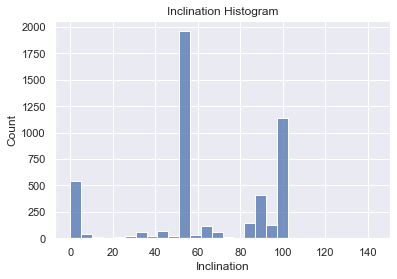

In [6]:
# show the distribution of inclinations
sns.set(rc={'figure.figsize':(11.7,8.27)})
data = df_123[df_123['Inclination'] < 180]
sns.histplot(data=data, x='Inclination')
plt.title('Inclination Histogram')
plt.show()

The above plot represents the number of orbit at each orbital inclination. The inclination represents how far north (or south) an orbit goes on its journey. An inclination of 0 always goes around the equator, and an inclination of 90 always goes over the poles. Inclinations above 90 orbit in the opposite direction. Here, we see that the inclinations hover around 3 main values. The values are roughly 0, 55, and 100. There are real-life reasons to expect these values (which I won't get into), but its good to see it show up in the data!

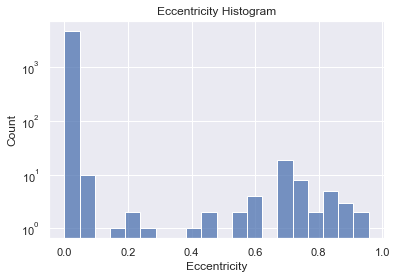

In [7]:
# show the distribution of eccentricities
sns.histplot(data=df_123, x='Eccentricity', bins = 20)
plt.yscale('log')
plt.title('Eccentricity Histogram')
plt.show()

Here is a similar plot, but instead we used eccentricity. This is a measure of how much like a circle the orbit is. 0 is a perfect circle, and as it gets closer to 1 it gets more like an oval. We hat to use a log scale to get this all on the same plot. The **vast** majority of orbits are close to circular.

In [8]:
# plot 3
df_2.columns
longitude = df_2['Longitude_at_Epoch']
long_drift = df_2['Lon_drift_10_minutes']

def remove_EW(long):
    if long[-1] == "W":
        return float(long[:-2])
    elif long[-1] == "E":
        return float(long[:-2]) * -1
    else:
        return np.nan
longitude = df_2['Longitude_at_Epoch'].apply(remove_EW)
long_drift = df_2['Lon_drift_10_minutes'].apply(remove_EW)

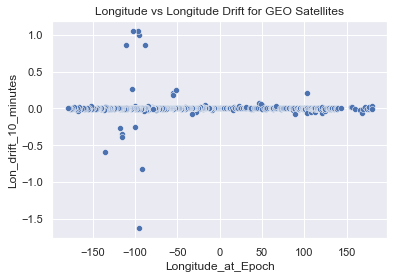

In [9]:
sns.scatterplot(x=longitude, y=long_drift)
plt.title('Longitude vs Longitude Drift for GEO Satellites')
plt.show()

This one is harder to explain. Some objects orbit in such a way that it looks like it is "hovering" over a point on the Earth. The x-axis shows what point on the Earth it is hovering over. The y-axis shows how much it drifts when it is hovering over that location. There's mainly one spot that deviates from the center line. That spot, it turns out, is over the Himalayas. When you make your satellite orbit near over there, the mass of the Himilayas pulls it a bit towards it (or so the story goes). This one I didn't expect to show up so nicely in the data.

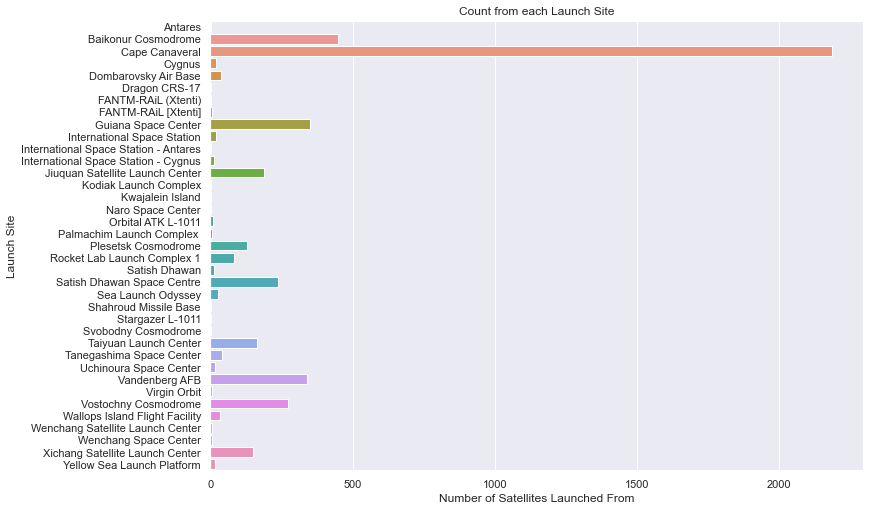

In [10]:
launch_counts = df_1.groupby(by='Launch_Site').count()['Unnamed:_0']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(y=launch_counts.index, x=launch_counts.values)
plt.xlabel('Number of Satellites Launched From')
plt.ylabel('Launch Site')
plt.title('Count from each Launch Site')
plt.show()

Here we show where these object are launched from. Pretty straight forward, nothing surprising here.

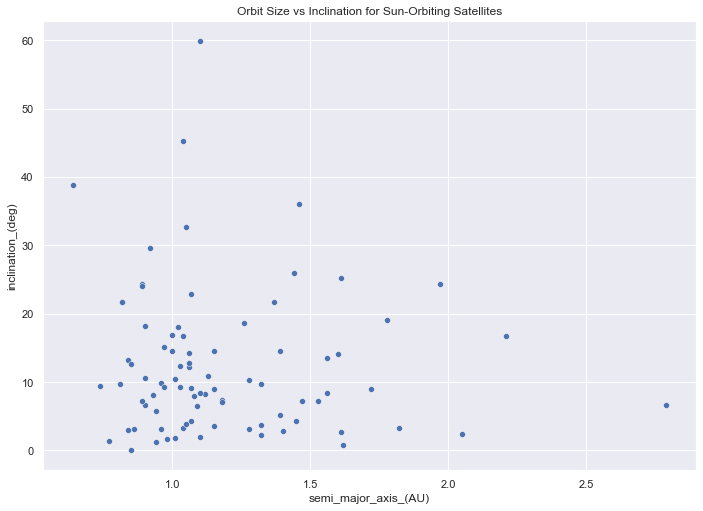

In [11]:
df_3.columns
sns.scatterplot(data=df_3, x='semi_major_axis_(AU)', y='inclination_(deg)')
plt.title('Orbit Size vs Inclination for Sun-Orbiting Satellites')
plt.show()

I wasn't sure how interesting this would be. This is looking at the asteroids in orbit. We are plotting how big the orbit is (x-axis) vs how inclined it is (y-axis). The larger the value on the y-axis is, the less it is orbiting in the same plane as the planets in the solar system.

In [12]:
# save data frame
df_123.to_csv('data/satellites.csv')